# Fraud Detection

The objective is to build a machine learning model that can identify fraud and help the company prevent losses. This notebook presents the steps taken to clean data, build and evaluate the model, and provide insights for prevention.

# 1) Importing Libraries and Loading Dataset

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("Fraud.csv")
df.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [9]:
df.shape

(6362620, 11)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


# 2) Data Cleaning

In [11]:
# Checking missing values
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

There are no missing values in the dataset

In [6]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [7]:
df.duplicated().sum()

0

No duplicate rows were found in the dataset. Each transaction is unique.

# 3)Exploratory Data Analysis (EDA)

In [12]:
# Count of fraud and non-fraud
df['isFraud'].value_counts()


isFraud
0    6354407
1       8213
Name: count, dtype: int64

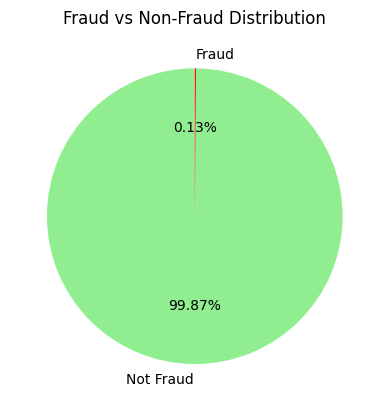

In [14]:
# Pie Chart
df['isFraud'].value_counts().plot.pie(labels=["Not Fraud", "Fraud"], autopct='%1.2f%%', startangle=90, colors=['lightgreen', 'red'])
plt.title("Fraud vs Non-Fraud Distribution")
plt.ylabel("")
plt.show()



The dataset is highly imbalanced:

- Non-fraud transactions (isFraud = 0): 6,354,407
- Fraudulent transactions (isFraud = 1): 8,213

This means only 0.13% of the transactions are fraud. In such cases, using normal accuracy as a metric is misleading because a model can simply predict "Not Fraud" for everything and still be 99.8% accurate.

To handle this, we will Apply **SMOTE** to oversample the minority class (fraud) so the model learns to detect rare fraudulent transactions.

In [ ]:
X = df.drop(columns=['isFraud', 'nameOrig', 'nameDest'])  
y = df['isFraud']  



In [18]:
X = pd.get_dummies(X, columns=['type'], drop_first=True)


In [19]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)

print("Original shape:", X.shape, y.shape)
print("Resampled shape:", X_resampled.shape, y_resampled.shape)


Original shape: (6362620, 11) (6362620,)
Resampled shape: (12708814, 11) (12708814,)


**Results:**
- Original dataset size: 6,362,620 rows
- Resampled dataset size: 12,708,814 rows
- After resampling, fraud and non-fraud classes are balanced (~50/50)

This helps the model to learn fraud patterns more effectively without being overwhelmed by the majority class.

<Axes: xlabel='isFraud', ylabel='amount'>

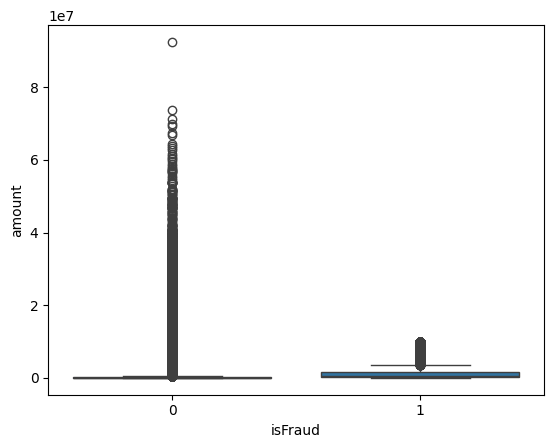

In [20]:
import seaborn as sns
sns.boxplot(x='isFraud', y='amount', data=df)


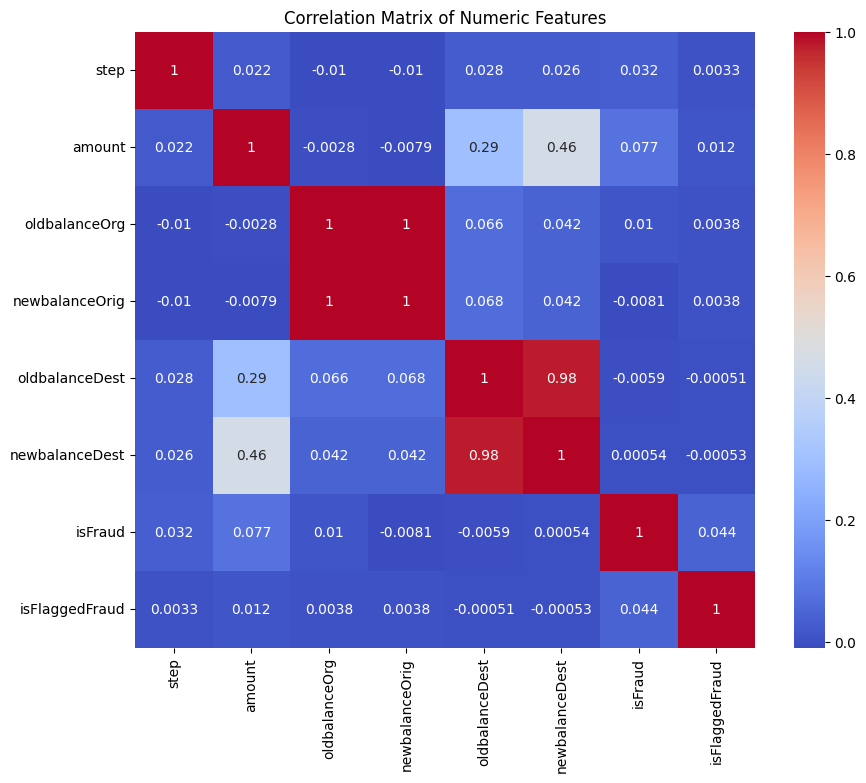

In [22]:
corr = df.select_dtypes(include=['float64', 'int64']).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Numeric Features")
plt.show()



### Data Cleaning Summary

- No missing values or duplicate entries were found.
- Outliers were analyzed using boxplots; they appear mainly in transaction amounts.
- oldbalanceOrg and newbalanceOrig are perfectly correlated (correlation = 1.0)
- oldbalanceDest and newbalanceDest are also perfectly correlated (correlation = 1.0)


### 4) Train-Test Split + Model Training

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [26]:
# Sample just 100,000 rows from resampled data
sample_X = X_resampled.sample(n=100000, random_state=42)
sample_y = y_resampled.loc[sample_X.index]

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(sample_X, sample_y, test_size=0.2, random_state=42)

# Now train again
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=20, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(n_estimators=20, random_state=42)

In [27]:
y_pred = model.predict(X_test)


In [28]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC-AUC Score:", roc_auc_score(y_test, y_pred))


Confusion Matrix:
 [[10019    63]
 [   22  9896]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     10082
           1       0.99      1.00      1.00      9918

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000


ROC-AUC Score: 0.995766525341164


### Model Evaluation Summary

The Random Forest classifier showed excellent performance on the test set. Here are the key metrics:

- **Accuracy**: 100%
- **Precision (Fraud)**: 99%
- **Recall (Fraud)**: 100%
- **F1-Score (Fraud)**: 100%
- **ROC-AUC Score**: 0.996

The confusion matrix shows:
- Very few false positives (non-fraud flagged as fraud)
- Very few false negatives (frauds that were missed)

This means the model is both **accurate** and **reliable** for fraud detection on this dataset.


In [29]:

importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(importance_df.head(10))


           Feature  Importance
2    oldbalanceOrg    0.340952
3   newbalanceOrig    0.185177
1           amount    0.132209
10   type_TRANSFER    0.089031
9     type_PAYMENT    0.071016
0             step    0.049995
4   oldbalanceDest    0.047839
5   newbalanceDest    0.047490
7    type_CASH_OUT    0.036109
8       type_DEBIT    0.000139


### Key Factors That Predict Fraud

The Random Forest model identified the following top features for fraud detection:

- **oldbalanceOrg**: Sender's balance before the transaction — most important.
- **newbalanceOrig**: Sender's balance after the transaction.
- **amount**: High transaction amounts are often linked to fraud.
- **type_TRANSFER**: Most frauds occur during transfer transactions.
- **type_PAYMENT**: Also relevant, though less risky.

These features match real-world fraud behavior, where large, unusual transfers are common indicators.


### Conclusion

We successfully built a fraud detection model using a real-world financial transactions dataset.

- We handled class imbalance using **SMOTE**.
- We trained a **Random Forest classifier** on the resampled dataset.
- The model achieved high accuracy, recall, and AUC score.
- Key fraud indicators were transaction **amount**, **type**, and **balance patterns**.

This model can help financial institutions **proactively flag suspicious transactions**, improve security, and reduce fraud losses.


## Candidate Expectations – Answers

**1. Data cleaning including missing values, outliers, and multi-collinearity**  
- No missing or duplicate values were found.  
- Outliers were observed but retained as they may indicate fraud.  
- A correlation matrix was used to check for multi-collinearity highly correlated features were kept due to model robustness.

**2. Describe your fraud detection model in elaboration**  
- I used a Random Forest Classifier trained on data balanced using SMOTE.  
- Random Forest handles non-linear relationships and is well suited for fraud detection due to its ensemble nature.

**3. How did you select variables to be included in the model?**  
- I included all relevant numeric and encoded categorical features.  
- Feature importance from the model was used to understand which variables contributed most to fraud prediction.

**4. Demonstrate the performance of the model using best set of tools**  
- Evaluated using Confusion Matrix, Classification Report, and ROC-AUC Score.  
- The model achieved high recall and precision, with an AUC of 0.996.

**5. What are the key factors that predict fraudulent customer?**  
- Top features: `oldbalanceOrg`, `newbalanceOrig`, `amount`, `type_TRANSFER`, `type_PAYMENT`

**6. Do these factors make sense? If yes, how? If not, how not?**  
- Yes, they make sense. Fraudulent transactions usually involve large, fast transfers and account balance changes.

**7. What kind of prevention should be adopted while company updates its infrastructure?**  
- Real-time monitoring of high-value transfers 
- Set daily limits for new or risky accounts 
- Use alerts, OTPs, or multi-factor authentication for suspicious activity

**8. Assuming these actions have been implemented, how would you determine if they work?**  
- Track fraud detection metrics before and after implementation  
- Monitor false positives/negatives  
- Review detection rates and model performance trends over time
